In [11]:
import warnings

import numpy as np
np.set_printoptions(linewidth=100)
from scipy.interpolate import CubicSpline, interp1d, UnivariateSpline
from scipy.special import hyp2f1
from scipy.optimize import fsolve

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
plt.rcParams['text.usetex'] = False

from mcfit import P2xi, xi2P
from avgem import avg

In [12]:
def pltmat(M, scale='symlog', vlim=None, linthresh=None, linscale=1, sav=None):
    if M.shape[0] > 1000:
        plot = plt.matshow
    else:
        plot = plt.pcolormesh
    
    if vlim is None:
        vlim = np.abs(M).max()
        
    if scale == 'linear':
        plot(M, vmin=-vlim, vmax=vlim, cmap='RdBu_r')
    elif scale == 'symlog':
        if linthresh is None:
            linthresh = 1e-4 * vlim
        plot(M, norm=SymLogNorm(linthresh=linthresh, linscale=linscale,
                                vmin=-vlim, vmax=vlim), cmap='RdBu_r')
    else:
        raise ValueError
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()
    
    if sav:
        plt.savefig(sav)

def z2x(z, Om=0.31):
    """flat ΛCDM comoving distance χ in Mpc/h"""
    z = np.asarray(z)
    OL = 1 - Om
    a = 1 / (1+z)
    return 2997.92458 * OL**-.5 * (hyp2f1(1/3, 1/2, 4/3, -Om*a**-3/OL) / a
                                - hyp2f1(1/3, 1/2, 4/3, -Om/OL))

def x2z(x, Om=0.31):
    """Inverse of z2x()
    """
    x = np.asarray(x)
    if any(xi >= z2x(1e3) for xi in x):
        warnings.warn("χ too large, touching the last scattering surface")
    z = fsolve(lambda y: z2x(y, Om=Om) - x, x / 2997.92458)
    return z

def growth(z, Om=0.31, norm='MD'):
    """flat ΛCDM growth function

    Parameters
    ----------
    norm : str, optional
        - 'MD' (default): normalized to a at matter-dominated era
        - '0': normalized to 1 at redshift zero
    """
    z = np.asarray(z)
    OL = 1 - Om
    a = 1 / (1+z)
    if norm == 'MD':
        return a * hyp2f1(1, 1/3, 11/6, -OL*a**3/Om)
    elif norm == '0':
        return a * hyp2f1(1, 1/3, 11/6, -OL*a**3/Om) \
                / hyp2f1(1, 1/3, 11/6, -OL/Om)

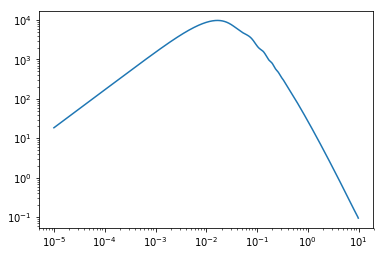

In [13]:
#why 729?
def get_Pk(lgkmin=-5, lgkmax=1, Nk=729):
    k = np.logspace(lgkmin, lgkmax, num=Nk, endpoint=False)
    path = '/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/CrossPostBorn/data/class_postlimberdensity/diagnostic/'
    P = CubicSpline(*np.loadtxt(path+"diagnostic_tophatz1nolimb_pk.dat", unpack=True))(k)
    return k, P

k, P = get_Pk()
# k, P = get_Pk(Nk=2187)
# k, P = get_Pk(Nk=1024)
# k, P = get_Pk(Nk=512)
# k, P = get_Pk(lgkmin=-4, lgkmax=0, Nk=486)
plt.loglog(k, P)
plt.show()

In [14]:
def get_H(k, l, lowring=False):
    """Return Hankel circulant matrix of j_l"""
    _, _, H = P2xi(k, l=l, N=len(k), lowring=lowring).matrix(full=False)
    return H

def rescale_rr(r, power):
    return r[:, None]**power * r**power

def k2rr(k, P, l, lowring=False):
    """k-to-r1-r2 transform
    
    k, P : array_like
    l : int
    """
    H = get_H(k, l, lowring=lowring)
    
    C = H * P
    r, C = P2xi(k, l=l, N=len(k), lowring=lowring)(C, axis=1, extrap=False, convonly=True)
    
    dlnr = np.diff(np.log(r[:2]))
    C *= 2 * np.pi**2 / dlnr / rescale_rr(r, 1.5)
#     C *= 2 * np.pi**2 / dlnr
    
    return r, C

In [184]:
z_ = np.linspace(1e-3,100,100000)
x_ = z2x(z_)
#central difference
diff = (x_[2::]-x_[:-2])/(z_[2::]-z_[:-2])
dxdz=interp1d(z_[1:-1],diff,bounds_error=True)
print(min(z_[1:-1]))

0.002


In [185]:
import Cosmology as C
import Constants as const

H_0 = C.Planck2015[1]['h']*100
Omega_m0 = (C.Planck2015[1]['omega_cdm']+C.Planck2015[1]['omega_b'])/C.Planck2015[1]['h']**2

lens_prefac = 1.5*H_0**2.*Omega_m0/(const.LIGHT_SPEED**2)

def CMB_lens(chicmb):
    def kernel(x,z,chimax=None):
        if chimax is None:
            chimax=chicmb
        w = np.ones(x.shape)
        w[x>chimax]==0.
        return (1+z)*x*w*(chimax-x)/chimax*lens_prefac*dxdz(z)
    return kernel

kernel = CMB_lens(z2x(1089.))

In [186]:
avg?

In [187]:
def get_Cl(k, P, ell, w, wp,z_bin=[0.01, 10], deg=0):
    r, _ = k2rr(k, P, 0)
    r_lo, r_hi = (z2x(0.01),z2x(10))
    i_r_lo = (r > r_lo).argmax()
    i_r_hi = (r > r_hi).argmax()
    sl = slice(i_r_lo, i_r_hi)
    r = r[sl]
    z = x2z(r)
    D = growth(z, norm='0')
    weight = kernel(r,z)
    w = w(r)
    wp = wp(r,z)
    Cl = np.zeros_like(ell, dtype=float)
    for l in ell:
        _, C = k2rr(k, P, l)
        
        C = C[sl, sl]
        C *= D[:, None] * D
        
        #print(C.shape,z.shape,min(z),max(z))
        C, _ = avg(z, C, z_bin, w=w, wp=wp, k=deg, axis=0)
        C, _ = avg(z, C, z_bin, w=w, wp=wp, k=deg, axis=1)
        
        Cl[l] = C
    
    return Cl

In [188]:
def kernel1(x):
    return np.ones(len(x))
def kernel2(x):
    return 2.*np.ones(len(x))

In [189]:
ell = range(1000)
#Cl0 = get_Cl(k,P, ell)
%time Cl1 = get_Cl(*get_Pk(lgkmin=-4, lgkmax=0), ell,w=kernel1, wp=kernel,deg=3)
#%time Cl0 = get_Cl(*get_Pk(lgkmin=-4, lgkmax=0), ell,w=kernel1, wp=kernel2, deg=3)
#%time Cl1 = get_Cl(k,P, ell, deg=3)

CPU times: user 30.1 s, sys: 14.4 s, total: 44.4 s
Wall time: 44.4 s


In [190]:
Cl = Cl1[2:]
ell = ell[2:]

In [191]:
import pickle
path='/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/ClassCls/'
params, clunl, cllen =pickle.load(open(path+'class_cls_Planck2015.pkl','rb'), encoding='latin1')
ll = cllen['ell'][2:1000]
clkk = cllen['pp'][2:1000]*(ll*(ll+1))**2/4.

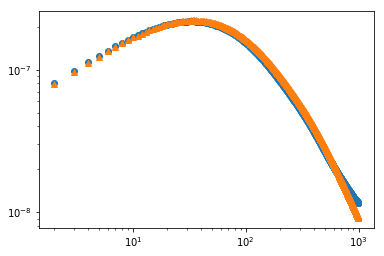

0.015871803913042125
0.001485765090613432


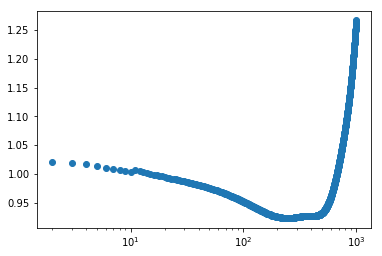

In [197]:
#plt.semilogx(Cl0)

plt.loglog(ell,Cl/0.015871803913042125,ls='',marker='o')
#plt.semilogx(ell,Cl0,ls='',marker='o')
plt.semilogx(ll,clkk,ls='', marker ='^')
#print(Cl1/clkk)
plt.show()
print(np.mean(Cl/clkk))
print(np.std(Cl/clkk))

fac=0.015871803913042125
plt.figure()
plt.semilogx(ell,Cl/fac/clkk,ls='',marker='o')
plt.show()

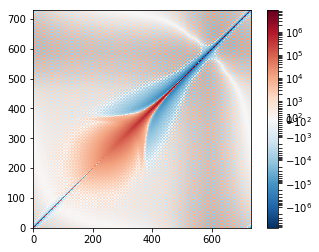

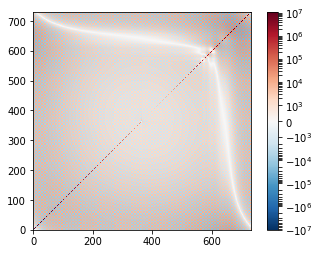

In [10]:
r, H = k2rr(k, P, 0)
H *= rescale_rr(r, 1.5)
pltmat(H, scale='symlog')
plt.show()
r, H = k2rr(k, P, 1000)
H *= rescale_rr(r, 1.5)
pltmat(H, scale='symlog')
plt.show()

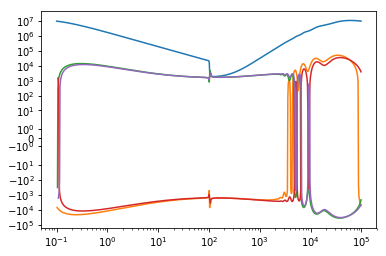

In [11]:
for i in range(5):
    plt.plot(r[i:], H.diagonal(offset=i))
plt.xscale('log')
plt.yscale('symlog')

In [12]:
z2x([0.9, 1.1])

array([2125.66988478, 2462.68053261])